Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 3  
Due: May 27, 2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import dask.array as da
import dask
import xarray as xr
import seaborn as sns

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
wd="/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw3"
data_dir=wd+"/data/"
model_dir=wd+"/models/"

cropped_dir=data_dir + "yale_cropped/"
uncropped_dir=data_dir + "yale_uncropped/"

### Functions

In [4]:
import glob
def fn_list(thisDir, fn_pattern):
    '''
    Function that returns a sorted list of filenames 
    based on a regex pattern in specified directory
    '''
    fns=[]
    for f in glob.glob(thisDir + "/" + fn_pattern): fns.append(f)
    fns.sort()
    return fns

#### Figure formatting

In [6]:
y_position=0.92
fontsize=16
weight="bold"

### Load data

In [7]:
cropped_fns = fn_list(data_dir+"yale_cropped/yale*", "*")
uncropped_fns = fn_list(data_dir+"yale_uncropped", "*")

# Start with cropped images 

#### With delayed 

In [8]:
%%time
xr_rio = dask.delayed(xr.open_rasterio, pure=True)

# Delayed
lazy=[xr_rio(fn) for fn in cropped_fns] 

# Get template
f=lazy[0].compute()

# Create dask array for image cube
arrays=[da.from_delayed(x, 
                      shape=f.shape, 
                      dtype=f.dtype) 
      for x in lazy]
stack = da.concatenate(arrays, axis=0)

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


CPU times: user 338 ms, sys: 11.8 ms, total: 350 ms
Wall time: 350 ms


In [9]:
stack

dask.array<concatenate, shape=(2432, 192, 168), dtype=uint8, chunksize=(1, 192, 168)>

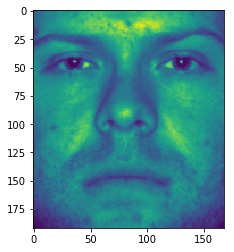

In [10]:
plt.imshow(stack[0])

## Question 1. Do an SVD analysis of the images

#### Reshape stack with images as column vectors (1D) and each image as a new column

In [13]:
%%time
# Create dask array for SVD analysis
arrays=[da.from_delayed(x, 
                      shape=f.shape, 
                      dtype=f.dtype) 
      for x in lazy]

rav_stack=[np.array(x).ravel() for x in arrays]
rav_stack = da.stack(rav_stack, axis=1)

CPU times: user 14.9 s, sys: 1.17 s, total: 16 s
Wall time: 16.8 s


In [20]:
%%time
# Convert to numpy array
rav_stack = np.array(rav_stack)

CPU times: user 916 ms, sys: 79.1 ms, total: 995 ms
Wall time: 910 ms


#### Direct computation with scipy (np.linalg.svd took twice as long)

In [84]:
%%time
import scipy 
u, s, v = scipy.linalg.svd(rav_stack)

CPU times: user 41min 57s, sys: 1min 40s, total: 43min 37s
Wall time: 2min 14s


In [123]:
print("u:", u.shape)
print("s:", s.shape)
print("v:", v.shape)

u: (32256, 32256)
s: (2432,)
v: (2432, 2432)


#### Truncated computation with sklearn

In [94]:
%%time
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
svd.fit(rav_stack)

CPU times: user 32.9 s, sys: 16 s, total: 48.9 s
Wall time: 4.8 s


---

## Question 2. What is the interpretation of the U, Σ and V matrices?

U

Σ

V

---

## Question 3. What does the singular value spectrum look like and how many modes are necessary for good image reconstructions? (i.e. what is the rank r of the face space?)

Modes > 0.00%:  6


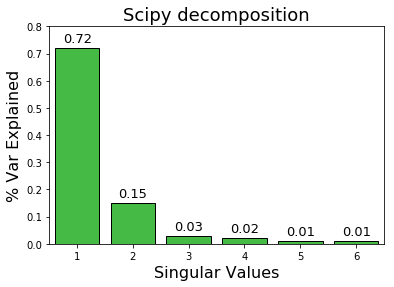

In [126]:
var_explained = np.round(s**2/np.sum(s**2), decimals=2)
print("Modes > 0.00%: ", 
      len(var_explained[var_explained>0]))

subset=len(var_explained[var_explained>0])
fig, ax = plt.subplots(figsize=(6, 4))
svd_bars = sns.barplot(x=list(range(1,len(var_explained[:subset])+1)),
                       y=var_explained[:subset], color="limegreen", ec='k', ax=ax)
ax.set_xlabel('Singular Values', fontsize=16)
ax.set_ylabel('% Var Explained', fontsize=16)
ax.set_ylim(0, 0.8)

# Label the bars
for p in svd_bars.patches:
    width = p.get_width()
    ax.text(p.get_x() + p.get_width()/2., 
            p.get_height()+0.01, 
            np.round(p.get_height(), 2), 
            fontsize=13, color='k', ha='center', va='bottom')

plt.title("Scipy decomposition", fontsize=18);

Modes > 0.00%:  6


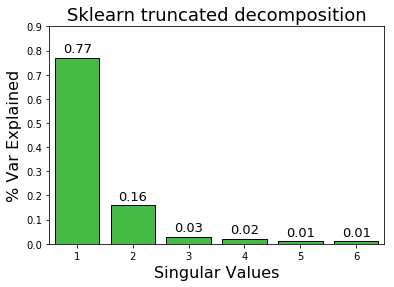

In [125]:
var_explained = np.round(svd.singular_values_**2/np.sum(svd.singular_values_**2), 2)
print("Modes > 0.00%: ", 
      len(var_explained[var_explained>0]))

subset=len(var_explained[var_explained>0])
fig, ax = plt.subplots(figsize=(6, 4))
svd_bars = sns.barplot(x=list(range(1,len(var_explained[:subset])+1)),
                       y=var_explained[:subset], color="limegreen", ec='k', ax=ax)
ax.set_xlabel('Singular Values', fontsize=16)
ax.set_ylabel('% Var Explained', fontsize=16)
ax.set_ylim(0, 0.9)

# Label the bars
for p in svd_bars.patches:
    width = p.get_width()
    ax.text(p.get_x() + p.get_width()/2., 
            p.get_height()+0.01, 
            np.round(p.get_height(), 2), 
            fontsize=13, color='k', ha='center', va='bottom')
plt.title("Sklearn truncated decomposition", fontsize=18);

#### Face space rank *r* is 6

---

## Repeat analysis for uncropped images 

In [136]:
%%time
# Delayed
lazy=[xr_rio(fn) for fn in uncropped_fns] 

# Get template
f=lazy[0].compute()

# Create dask array for image cube
arrays=[da.from_delayed(x, 
                      shape=f.shape, 
                      dtype=f.dtype) 
      for x in lazy]
stack = da.concatenate(arrays, axis=0)
stack

CPU times: user 22.2 ms, sys: 79 µs, total: 22.3 ms
Wall time: 21.2 ms


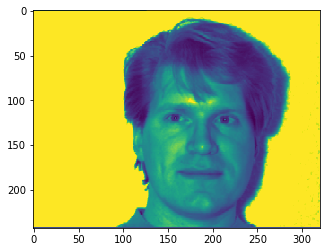

In [130]:
plt.imshow(stack[0])

In [141]:
test_fn=uncropped_fns[0]
test_fn

'/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw3/data/yale_uncropped/subject01.centerlight'

In [144]:
%%time
# Create dask array for SVD analysis
arrays=[da.from_delayed(x, 
                      shape=f.shape, 
                      dtype=f.dtype) 
      for x in lazy]

rav_stack=[np.array(x).ravel() for x in arrays]
rav_stack = da.stack(rav_stack, axis=1)

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ra

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ra

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ra

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ra

CPU times: user 1.45 s, sys: 85.7 ms, total: 1.54 s
Wall time: 1.57 s


/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ra

In [145]:
%%time
# Convert to numpy array
rav_stack = np.array(rav_stack)

CPU times: user 106 ms, sys: 16 ms, total: 122 ms
Wall time: 116 ms


In [146]:
rav_stack

array([[130, 130, 130, ..., 130, 130, 130],
       [130, 130, 130, ..., 130, 130, 130],
       [130, 130, 130, ..., 130, 130, 130],
       ...,
       [ 68,  68,  68, ...,  68,  68,  68],
       [ 68,  68,  68, ...,  68,  68,  68],
       [ 68,  68,  68, ...,  68,  68,  68]], dtype=uint8)

In [147]:
%%time
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
svd.fit(rav_stack)

CPU times: user 12.3 s, sys: 10.7 s, total: 23 s
Wall time: 1.27 s


Modes > 0.00%:  5


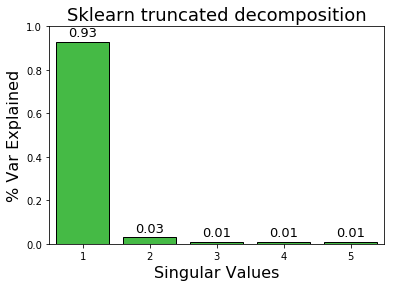

In [151]:
var_explained = np.round(svd.singular_values_**2/np.sum(svd.singular_values_**2), 2)
print("Modes > 0.00%: ", 
      len(var_explained[var_explained>0]))

subset=len(var_explained[var_explained>0])
fig, ax = plt.subplots(figsize=(6, 4))
svd_bars = sns.barplot(x=list(range(1,len(var_explained[:subset])+1)),
                       y=var_explained[:subset], color="limegreen", ec='k', ax=ax)
ax.set_xlabel('Singular Values', fontsize=16)
ax.set_ylabel('% Var Explained', fontsize=16)
ax.set_ylim(0, 1.0)

# Label the bars
for p in svd_bars.patches:
    width = p.get_width()
    ax.text(p.get_x() + p.get_width()/2., 
            p.get_height()+0.01, 
            np.round(p.get_height(), 2), 
            fontsize=13, color='k', ha='center', va='bottom')
plt.title("Sklearn truncated decomposition", fontsize=18);